# Vesuvius Challenge: Refactored Training Pipeline (Topology Refinement)

## Phase 6: Topology Optimization with clDice
Now that the baseline is stable (Dice ~0.41), we focus on the **Merge Score** (currently 1.0, showing some bridging).
We introduce **clDice (Centerline Dice Loss)** to regularize the topology. This discourages the model from predicting massive blobs or disconnected fragments by penalizing deviations from the vessel/sheet skeletons.

**Configuration:**
- **Loss**: 40% BCE + 40% Dice + **20% clDice**.
- **Epochs**: 50.
- **Scheduler**: CosineAnnealingLR.
- **Fixes Retained**: Volume Norm, Target Label 1, Sparse Sampling.

In [1]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import tifffile
import cv2

import sys
sys.path.append('src')

from models.unet3d import AttentionUNet3D
from data.dataset import MultiVolumePatchDataset
from utils.topology import calculate_merge_score, calculate_dice
from utils.inference import predict_sliding_window
from losses.cldice import soft_cldice # NEW IMPORT

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cuda


In [2]:
# --- DATA SETUP ---
DATA_DIR = Path('data')
TRAIN_IMG_DIR = DATA_DIR / 'train_images'
TRAIN_LBL_DIR = DATA_DIR / 'train_labels'

all_volumes = sorted(list(TRAIN_IMG_DIR.glob('*.tif')))
all_labels = [TRAIN_LBL_DIR / v.name for v in all_volumes]

np.random.seed(42)
indices = np.arange(len(all_volumes))
np.random.shuffle(indices)

split_idx = int(0.8 * len(indices))
train_idx = indices[:split_idx]

# Ensure we have at least 1 val volume
if split_idx < len(indices):
    val_idx = indices[split_idx:]
else:
    val_idx = [indices[-1]]

train_vols = [all_volumes[i] for i in train_idx]
train_lbls = [all_labels[i] for i in train_idx]

# Limited Validation Set
val_vols_paths = [all_volumes[i] for i in val_idx][:2]
val_lbls_paths = [all_labels[i] for i in val_idx][:2]

print(f"Train Count: {len(train_vols)}")
print(f"Val Count: {len(val_vols_paths)} (Using: {[v.name for v in val_vols_paths]}) ")

Train Count: 644
Val Count: 2 (Using: ['3409971532.tif', '4105398542.tif']) 


In [3]:
# --- CONFIG ---
BATCH_SIZE = 1
GRAD_ACCUM_STEPS = 16
PATCH_SIZE = (32, 128, 128)
EPOCHS = 50
SAMPLES_PER_EPOCH = 1600
LR = 3e-5

train_dataset = MultiVolumePatchDataset(
    train_vols, train_lbls, 
    patch_size=PATCH_SIZE, 
    samples_per_epoch=SAMPLES_PER_EPOCH, 
    pos_fraction=0.1, 
    target_label_val=1
)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=0, pin_memory=True)

# Model
model = AttentionUNet3D(
    attention=True, 
    depth=3, 
    pool_kernel_size=(1, 2, 2)
).to(device)

# --- CUSTOM LOSS (Composite) ---
class SoftDiceLoss(torch.nn.Module):
    def __init__(self, smooth=1.0):
        super().__init__()
        self.smooth = smooth

    def forward(self, logits, targets):
        probs = torch.sigmoid(logits)
        probs = probs.view(-1)
        targets = targets.view(-1)
        intersection = (probs * targets).sum()
        dice = (2. * intersection + self.smooth) / (probs.sum() + targets.sum() + self.smooth)
        return 1 - dice

bce_fn = torch.nn.BCEWithLogitsLoss()
dice_fn = SoftDiceLoss()
cldice_fn = soft_cldice(iter_=3) # 3 iterations of skeletonization

def criterion(logits, targets):
    # Composite Loss: 40% BCE, 40% Dice, 20% clDice
    # Note: clDice takes (B,C,D,H,W) and Probs, not logits
    return 0.4 * bce_fn(logits, targets) + 0.4 * dice_fn(logits, targets) + 0.2 * cldice_fn(torch.sigmoid(logits), targets)

# Optimizer & Scheduler
optimizer = optim.AdamW(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)
scaler = torch.amp.GradScaler('cuda')

# Checkpointing
save_dir = Path('models')
save_dir.mkdir(exist_ok=True)
img_dir = Path('debug_images') 
img_dir.mkdir(exist_ok=True)

history = {'train_loss': [], 'val_dice': [], 'val_merge': []}
best_dice = 0.0
best_merge = float('inf')

print("Starting Deterministic Training Loop (with clDice)...")

for epoch in range(EPOCHS):
    # --- TRAIN ---
    model.train()
    train_loss = 0
    optimizer.zero_grad()
    
    pbar = tqdm(train_loader, desc=f"Ep {epoch+1} Train")
    for i, batch in enumerate(pbar):
        vol = batch['volume'].to(device)
        lbl = batch['label'].to(device)
        
        with torch.amp.autocast('cuda'):
            preds = model(vol)
            loss = criterion(preds, lbl) / GRAD_ACCUM_STEPS
            
        scaler.scale(loss).backward()
        
        if (i + 1) % GRAD_ACCUM_STEPS == 0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            
        train_loss += loss.item() * GRAD_ACCUM_STEPS
        pbar.set_postfix({'loss': loss.item() * GRAD_ACCUM_STEPS})
    
    # Step Scheduler
    scheduler.step()
    current_lr = scheduler.get_last_lr()[0]
    history['train_loss'].append(train_loss / len(train_loader))
    
    # --- DET VALIDATION (Sliding Window) ---
    print(f"  Running Validation on {len(val_vols_paths)} volumes...")
    val_dice_metrics = []
    val_merge_metrics = []
    
    for v_path, l_path in zip(val_vols_paths, val_lbls_paths):
        try:
            # Use 1 for GT Mask here too
            gt_vol = tifffile.imread(l_path)
            gt_vol = (gt_vol == 1).astype(np.float32) # Target Ink
            
            inp_vol = tifffile.imread(v_path).astype(np.float32)
            # Fix Validation Norm too (Autodetect 8-bit)
            max_v = inp_vol.max()
            if max_v <= 255:
                 inp_vol = inp_vol / 255.0
            else:
                 inp_vol = (inp_vol - inp_vol.min()) / (inp_vol.max() - inp_vol.min() + 1e-6)
                 
        except Exception as e:
            print(f"Skipping {v_path.name} due to read error: {e}")
            continue

        # Predict
        pred_vol = predict_sliding_window(model, inp_vol, patch_size=PATCH_SIZE, overlap=0.25, device=device)
        
        # Sanity Check & Visualization
        if len(val_dice_metrics) == 0: # Check first volume only
            print(f"    [DEBUG] Pred Stats: Min={pred_vol.min():.4f}, Mean={pred_vol.mean():.4f}, Max={pred_vol.max():.4f}")
            # Save middle slice
            mid_z = pred_vol.shape[0] // 2
            slice_img = (pred_vol[mid_z] * 255).astype(np.uint8)
            cv2.imwrite(str(img_dir / f'ep{epoch+1}_z{mid_z}.png'), slice_img)
        
        D, H, W = gt_vol.shape
        pred_vol = pred_vol[:D, :H, :W]
        
        d_score = calculate_dice(torch.from_numpy(pred_vol), torch.from_numpy(gt_vol), threshold=0.5)
        m_score = calculate_merge_score(pred_vol, gt_vol, threshold=0.5)
        
        val_dice_metrics.append(d_score.item())
        val_merge_metrics.append(m_score)
        
        del inp_vol, gt_vol, pred_vol
        torch.cuda.empty_cache()

    if len(val_dice_metrics) > 0:
        epoch_dice = np.mean(val_dice_metrics)
        epoch_merge = np.mean(val_merge_metrics)
    else:
        epoch_dice = 0
        epoch_merge = 999

    history['val_dice'].append(epoch_dice)
    history['val_merge'].append(epoch_merge)
    
    print(f"  Ep {epoch+1} Metrics: Dice {epoch_dice:.4f} | Merge Score {epoch_merge:.2f}")
    
    if epoch_dice > best_dice:
        best_dice = epoch_dice
        torch.save(model.state_dict(), save_dir / 'best_dice_cldice.pth') # Updated Name
        
    if epoch_merge < best_merge:
        best_merge = epoch_merge
        torch.save(model.state_dict(), save_dir / 'best_topology_cldice.pth') # Updated Name

Initializing Dataset with 644 volumes (Target Label: 1)...
Starting Deterministic Training Loop (with clDice)...


Ep 1 Train:   0%|          | 0/1600 [00:00<?, ?it/s]

  Running Validation on 2 volumes...
    [DEBUG] Pred Stats: Min=0.0558, Mean=0.3207, Max=0.7441
  Ep 1 Metrics: Dice 0.1467 | Merge Score 15.00


Ep 2 Train:   0%|          | 0/1600 [00:00<?, ?it/s]

  Running Validation on 2 volumes...
    [DEBUG] Pred Stats: Min=0.0412, Mean=0.2962, Max=0.7153
  Ep 2 Metrics: Dice 0.2097 | Merge Score 11.00


Ep 3 Train:   0%|          | 0/1600 [00:00<?, ?it/s]

  Running Validation on 2 volumes...
    [DEBUG] Pred Stats: Min=0.0393, Mean=0.2718, Max=0.6704
  Ep 3 Metrics: Dice 0.1791 | Merge Score 7.50


Ep 4 Train:   0%|          | 0/1600 [00:00<?, ?it/s]

  Running Validation on 2 volumes...
    [DEBUG] Pred Stats: Min=0.0201, Mean=0.2799, Max=0.6748
  Ep 4 Metrics: Dice 0.2727 | Merge Score 12.00


Ep 5 Train:   0%|          | 0/1600 [00:00<?, ?it/s]

  Running Validation on 2 volumes...
    [DEBUG] Pred Stats: Min=0.0090, Mean=0.2763, Max=0.6836
  Ep 5 Metrics: Dice 0.3168 | Merge Score 8.00


Ep 6 Train:   0%|          | 0/1600 [00:00<?, ?it/s]

  Running Validation on 2 volumes...
    [DEBUG] Pred Stats: Min=0.0078, Mean=0.2613, Max=0.7246
  Ep 6 Metrics: Dice 0.3067 | Merge Score 5.00


Ep 7 Train:   0%|          | 0/1600 [00:00<?, ?it/s]

  Running Validation on 2 volumes...
    [DEBUG] Pred Stats: Min=0.0058, Mean=0.2432, Max=0.7422
  Ep 7 Metrics: Dice 0.2480 | Merge Score 12.00


Ep 8 Train:   0%|          | 0/1600 [00:00<?, ?it/s]

  Running Validation on 2 volumes...
    [DEBUG] Pred Stats: Min=0.0038, Mean=0.2507, Max=0.7690
  Ep 8 Metrics: Dice 0.3008 | Merge Score 4.00


Ep 9 Train:   0%|          | 0/1600 [00:00<?, ?it/s]

  Running Validation on 2 volumes...
    [DEBUG] Pred Stats: Min=0.0034, Mean=0.2401, Max=0.7612
  Ep 9 Metrics: Dice 0.3259 | Merge Score 6.50


Ep 10 Train:   0%|          | 0/1600 [00:00<?, ?it/s]

  Running Validation on 2 volumes...
    [DEBUG] Pred Stats: Min=0.0016, Mean=0.2450, Max=0.7935
  Ep 10 Metrics: Dice 0.2996 | Merge Score 7.50


Ep 11 Train:   0%|          | 0/1600 [00:00<?, ?it/s]

  Running Validation on 2 volumes...
    [DEBUG] Pred Stats: Min=0.0016, Mean=0.2288, Max=0.8457
  Ep 11 Metrics: Dice 0.2685 | Merge Score 12.00


Ep 12 Train:   0%|          | 0/1600 [00:00<?, ?it/s]

  Running Validation on 2 volumes...
    [DEBUG] Pred Stats: Min=0.0007, Mean=0.2327, Max=0.8438
  Ep 12 Metrics: Dice 0.2321 | Merge Score 14.50


Ep 13 Train:   0%|          | 0/1600 [00:00<?, ?it/s]

  Running Validation on 2 volumes...
    [DEBUG] Pred Stats: Min=0.0024, Mean=0.2167, Max=0.8457
  Ep 13 Metrics: Dice 0.2610 | Merge Score 13.00


Ep 14 Train:   0%|          | 0/1600 [00:00<?, ?it/s]

  Running Validation on 2 volumes...
    [DEBUG] Pred Stats: Min=0.0009, Mean=0.2235, Max=0.8403
  Ep 14 Metrics: Dice 0.2858 | Merge Score 14.00


Ep 15 Train:   0%|          | 0/1600 [00:00<?, ?it/s]

  Running Validation on 2 volumes...
    [DEBUG] Pred Stats: Min=0.0025, Mean=0.2216, Max=0.8999
  Ep 15 Metrics: Dice 0.2885 | Merge Score 11.50


Ep 16 Train:   0%|          | 0/1600 [00:00<?, ?it/s]

  Running Validation on 2 volumes...
    [DEBUG] Pred Stats: Min=0.0022, Mean=0.2204, Max=0.8984
  Ep 16 Metrics: Dice 0.2641 | Merge Score 9.50


Ep 17 Train:   0%|          | 0/1600 [00:00<?, ?it/s]

  Running Validation on 2 volumes...
    [DEBUG] Pred Stats: Min=0.0007, Mean=0.2395, Max=0.8721
  Ep 17 Metrics: Dice 0.2980 | Merge Score 10.50


Ep 18 Train:   0%|          | 0/1600 [00:00<?, ?it/s]

  Running Validation on 2 volumes...
    [DEBUG] Pred Stats: Min=0.0007, Mean=0.2155, Max=0.8999
  Ep 18 Metrics: Dice 0.2748 | Merge Score 9.00


Ep 19 Train:   0%|          | 0/1600 [00:00<?, ?it/s]

  Running Validation on 2 volumes...
    [DEBUG] Pred Stats: Min=0.0007, Mean=0.2283, Max=0.9087
  Ep 19 Metrics: Dice 0.3378 | Merge Score 10.50


Ep 20 Train:   0%|          | 0/1600 [00:00<?, ?it/s]

  Running Validation on 2 volumes...
    [DEBUG] Pred Stats: Min=0.0004, Mean=0.2096, Max=0.9282
  Ep 20 Metrics: Dice 0.2157 | Merge Score 15.00


Ep 21 Train:   0%|          | 0/1600 [00:00<?, ?it/s]

  Running Validation on 2 volumes...
    [DEBUG] Pred Stats: Min=0.0005, Mean=0.2057, Max=0.9272
  Ep 21 Metrics: Dice 0.2846 | Merge Score 13.50


Ep 22 Train:   0%|          | 0/1600 [00:00<?, ?it/s]

  Running Validation on 2 volumes...
    [DEBUG] Pred Stats: Min=0.0003, Mean=0.2169, Max=0.9058
  Ep 22 Metrics: Dice 0.3346 | Merge Score 9.50


Ep 23 Train:   0%|          | 0/1600 [00:00<?, ?it/s]

  Running Validation on 2 volumes...
    [DEBUG] Pred Stats: Min=0.0005, Mean=0.2193, Max=0.9326
  Ep 23 Metrics: Dice 0.3118 | Merge Score 8.00


Ep 24 Train:   0%|          | 0/1600 [00:00<?, ?it/s]

  Running Validation on 2 volumes...
    [DEBUG] Pred Stats: Min=0.0006, Mean=0.1934, Max=0.9390
  Ep 24 Metrics: Dice 0.2882 | Merge Score 9.00


Ep 25 Train:   0%|          | 0/1600 [00:00<?, ?it/s]

  Running Validation on 2 volumes...
    [DEBUG] Pred Stats: Min=0.0007, Mean=0.2115, Max=0.9038
  Ep 25 Metrics: Dice 0.3243 | Merge Score 11.00


Ep 26 Train:   0%|          | 0/1600 [00:00<?, ?it/s]

  Running Validation on 2 volumes...
    [DEBUG] Pred Stats: Min=0.0002, Mean=0.2234, Max=0.9053
  Ep 26 Metrics: Dice 0.3526 | Merge Score 9.00


Ep 27 Train:   0%|          | 0/1600 [00:00<?, ?it/s]

  Running Validation on 2 volumes...
    [DEBUG] Pred Stats: Min=0.0001, Mean=0.2274, Max=0.9238
  Ep 27 Metrics: Dice 0.3822 | Merge Score 11.50


Ep 28 Train:   0%|          | 0/1600 [00:00<?, ?it/s]

  Running Validation on 2 volumes...
    [DEBUG] Pred Stats: Min=0.0002, Mean=0.1812, Max=0.9541
  Ep 28 Metrics: Dice 0.2949 | Merge Score 10.00


Ep 29 Train:   0%|          | 0/1600 [00:00<?, ?it/s]

  Running Validation on 2 volumes...
    [DEBUG] Pred Stats: Min=0.0003, Mean=0.2157, Max=0.9414
  Ep 29 Metrics: Dice 0.3399 | Merge Score 11.00


Ep 30 Train:   0%|          | 0/1600 [00:00<?, ?it/s]

  Running Validation on 2 volumes...
    [DEBUG] Pred Stats: Min=0.0001, Mean=0.1978, Max=0.9473
  Ep 30 Metrics: Dice 0.3120 | Merge Score 11.00


Ep 31 Train:   0%|          | 0/1600 [00:00<?, ?it/s]

  Running Validation on 2 volumes...
    [DEBUG] Pred Stats: Min=0.0003, Mean=0.2109, Max=0.9390
  Ep 31 Metrics: Dice 0.3331 | Merge Score 12.00


Ep 32 Train:   0%|          | 0/1600 [00:00<?, ?it/s]

  Running Validation on 2 volumes...
    [DEBUG] Pred Stats: Min=0.0001, Mean=0.2070, Max=0.9390
  Ep 32 Metrics: Dice 0.3140 | Merge Score 10.50


Ep 33 Train:   0%|          | 0/1600 [00:00<?, ?it/s]

  Running Validation on 2 volumes...
    [DEBUG] Pred Stats: Min=0.0002, Mean=0.1880, Max=0.9380
  Ep 33 Metrics: Dice 0.3018 | Merge Score 9.50


Ep 34 Train:   0%|          | 0/1600 [00:00<?, ?it/s]

  Running Validation on 2 volumes...
    [DEBUG] Pred Stats: Min=0.0003, Mean=0.2097, Max=0.9336
  Ep 34 Metrics: Dice 0.3248 | Merge Score 8.50


Ep 35 Train:   0%|          | 0/1600 [00:00<?, ?it/s]

  Running Validation on 2 volumes...
    [DEBUG] Pred Stats: Min=0.0001, Mean=0.2230, Max=0.9331
  Ep 35 Metrics: Dice 0.3629 | Merge Score 7.50


Ep 36 Train:   0%|          | 0/1600 [00:00<?, ?it/s]

  Running Validation on 2 volumes...
    [DEBUG] Pred Stats: Min=0.0001, Mean=0.2007, Max=0.9497
  Ep 36 Metrics: Dice 0.3277 | Merge Score 12.00


Ep 37 Train:   0%|          | 0/1600 [00:00<?, ?it/s]

  Running Validation on 2 volumes...
    [DEBUG] Pred Stats: Min=0.0001, Mean=0.2010, Max=0.9351
  Ep 37 Metrics: Dice 0.2990 | Merge Score 10.50


Ep 38 Train:   0%|          | 0/1600 [00:00<?, ?it/s]

  Running Validation on 2 volumes...
    [DEBUG] Pred Stats: Min=0.0001, Mean=0.2206, Max=0.9316
  Ep 38 Metrics: Dice 0.3466 | Merge Score 8.00


Ep 39 Train:   0%|          | 0/1600 [00:00<?, ?it/s]

  Running Validation on 2 volumes...
    [DEBUG] Pred Stats: Min=0.0001, Mean=0.2066, Max=0.9414
  Ep 39 Metrics: Dice 0.3346 | Merge Score 9.00


Ep 40 Train:   0%|          | 0/1600 [00:00<?, ?it/s]

  Running Validation on 2 volumes...
    [DEBUG] Pred Stats: Min=0.0001, Mean=0.1903, Max=0.9526
  Ep 40 Metrics: Dice 0.3167 | Merge Score 10.00


Ep 41 Train:   0%|          | 0/1600 [00:00<?, ?it/s]

  Running Validation on 2 volumes...
    [DEBUG] Pred Stats: Min=0.0002, Mean=0.2028, Max=0.9478
  Ep 41 Metrics: Dice 0.3452 | Merge Score 11.00


Ep 42 Train:   0%|          | 0/1600 [00:00<?, ?it/s]

  Running Validation on 2 volumes...
    [DEBUG] Pred Stats: Min=0.0001, Mean=0.1965, Max=0.9409
  Ep 42 Metrics: Dice 0.3157 | Merge Score 12.00


Ep 43 Train:   0%|          | 0/1600 [00:00<?, ?it/s]

  Running Validation on 2 volumes...
    [DEBUG] Pred Stats: Min=0.0001, Mean=0.2048, Max=0.9429
  Ep 43 Metrics: Dice 0.3391 | Merge Score 11.00


Ep 44 Train:   0%|          | 0/1600 [00:00<?, ?it/s]

  Running Validation on 2 volumes...
    [DEBUG] Pred Stats: Min=0.0001, Mean=0.1990, Max=0.9385
  Ep 44 Metrics: Dice 0.3133 | Merge Score 9.50


Ep 45 Train:   0%|          | 0/1600 [00:00<?, ?it/s]

  Running Validation on 2 volumes...
    [DEBUG] Pred Stats: Min=0.0002, Mean=0.2059, Max=0.9419
  Ep 45 Metrics: Dice 0.3397 | Merge Score 10.00


Ep 46 Train:   0%|          | 0/1600 [00:00<?, ?it/s]

  Running Validation on 2 volumes...
    [DEBUG] Pred Stats: Min=0.0002, Mean=0.2038, Max=0.9458
  Ep 46 Metrics: Dice 0.3307 | Merge Score 9.50


Ep 47 Train:   0%|          | 0/1600 [00:00<?, ?it/s]

  Running Validation on 2 volumes...
    [DEBUG] Pred Stats: Min=0.0002, Mean=0.1984, Max=0.9429
  Ep 47 Metrics: Dice 0.3217 | Merge Score 9.00


Ep 48 Train:   0%|          | 0/1600 [00:00<?, ?it/s]

  Running Validation on 2 volumes...
    [DEBUG] Pred Stats: Min=0.0001, Mean=0.2005, Max=0.9429
  Ep 48 Metrics: Dice 0.3287 | Merge Score 10.50


Ep 49 Train:   0%|          | 0/1600 [00:00<?, ?it/s]

  Running Validation on 2 volumes...
    [DEBUG] Pred Stats: Min=0.0001, Mean=0.2028, Max=0.9458
  Ep 49 Metrics: Dice 0.3394 | Merge Score 9.50


Ep 50 Train:   0%|          | 0/1600 [00:00<?, ?it/s]

  Running Validation on 2 volumes...
    [DEBUG] Pred Stats: Min=0.0002, Mean=0.2027, Max=0.9478
  Ep 50 Metrics: Dice 0.3471 | Merge Score 10.00


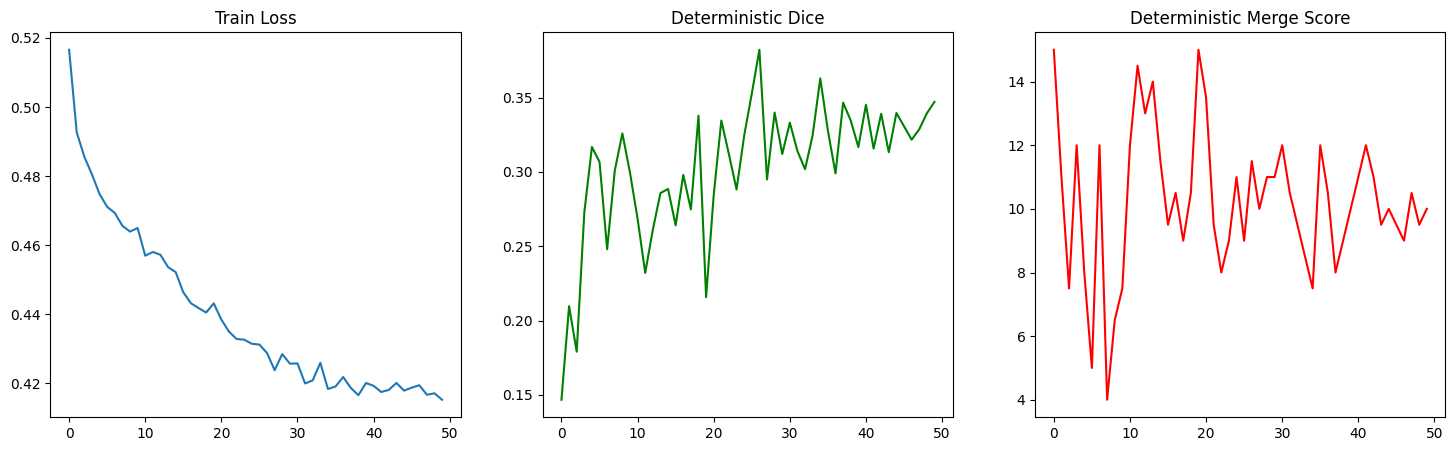

In [4]:
# Plotting Results
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
axes[0].plot(history['train_loss'])
axes[0].set_title('Train Loss')
axes[1].plot(history['val_dice'], color='green')
axes[1].set_title('Deterministic Dice')
axes[2].plot(history['val_merge'], color='red')
axes[2].set_title('Deterministic Merge Score')
plt.show()

## 7. Post-Training Analysis: Threshold Calibration


In [5]:
# Load Best Model
model = AttentionUNet3D(attention=True, depth=3, pool_kernel_size=(1, 2, 2)).to(device)

model_path = save_dir / 'best_topology_cldice.pth' # Prefer topology
if not model_path.exists():
    model_path = save_dir / 'best_dice_cldice.pth'

print(f"Loading for calibration: {model_path}")
model.load_state_dict(torch.load(model_path))
model.eval()

thresholds = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
results = {t: {'dice': 0, 'merge': 0} for t in thresholds}

print("Running Threshold Sweep (Deterministic)...")
with torch.no_grad():
    for v_path, l_path in zip(val_vols_paths, val_lbls_paths):
        gt_vol = tifffile.imread(l_path)
        gt_vol = (gt_vol == 1).astype(np.float32) # Target Ink
        
        inp_vol = tifffile.imread(v_path).astype(np.float32)
        max_v = inp_vol.max()
        if max_v <= 255:
             inp_vol = inp_vol / 255.0
        else:
             inp_vol = (inp_vol - inp_vol.min()) / (inp_vol.max() - inp_vol.min() + 1e-6)

        # Predict
        pred_probs = predict_sliding_window(model, inp_vol, patch_size=PATCH_SIZE, overlap=0.25, device=device)
        
        D, H, W = gt_vol.shape
        pred_probs = pred_probs[:D, :H, :W]

        for t in thresholds:
            d_score = calculate_dice(torch.from_numpy(pred_probs), torch.from_numpy(gt_vol), threshold=t).item()
            m_score = calculate_merge_score(pred_probs, gt_vol, threshold=t)
            results[t]['dice'] += d_score
            results[t]['merge'] += m_score

# Average
num_val = len(val_vols_paths)
print(f"{'Thresh':<8} | {'Dice':<8} | {'Merge (Low=Good)':<18}")
print("-"*50)
for t in thresholds:
    dice = results[t]['dice'] / num_val
    merge = results[t]['merge'] / num_val
    print(f"{t:<8.1f} | {dice:<8.4f} | {merge:<18.4f}")

Loading for calibration: models\best_topology_cldice.pth
Running Threshold Sweep (Deterministic)...
Thresh   | Dice     | Merge (Low=Good)  
--------------------------------------------------
0.3      | 0.4227   | 1.0000            
0.4      | 0.3681   | 6.0000            
0.5      | 0.3008   | 4.0000            
0.6      | 0.2083   | 6.5000            
0.7      | 0.0252   | 2.0000            
0.8      | 0.0000   | 0.0000            
